In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
import joblib
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


## 하의모델

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_after/bot.csv')
df.head()

,Unnamed: 0,customer_gender,customer_height,customer_weight,customer_size,major,sub,link,product_star,product_sales
0,0,0.0,175.0,75.0,2.0,bot,cot,https://www.musinsa.com/app/goods/957401,4.7,24000.0
1,1,0.0,178.0,75.0,2.0,bot,cot,https://www.musinsa.com/app/goods/1780712,4.8,5800.0
2,2,0.0,176.0,88.0,3.0,bot,cot,https://www.musinsa.com/app/goods/485406,4.7,1900.0
3,3,0.0,173.0,65.0,1.0,bot,cot,https://www.musinsa.com/app/goods/1155289,4.7,8900.0
4,4,0.0,172.0,75.0,3.0,bot,cot,https://www.musinsa.com/app/goods/965988,4.7,1300.0


In [ ]:
df['sub'].value_counts()

denim       7716
training    7469
half        7270
cot         6812
slax        6812
etc         1207
leggings     904
Name: sub, dtype: int64

In [ ]:
df = df[['customer_gender','customer_height','customer_weight','customer_size','sub']]
df.dtypes
bot = df

In [ ]:
df['sub'] = df['sub'].apply(lambda x: 0  if x == 'cot' else x)
df['sub'] = df['sub'].apply(lambda x: 1  if x == 'denim' else x)
df['sub'] = df['sub'].apply(lambda x: 2  if x == 'etc' else x)
df['sub'] = df['sub'].apply(lambda x: 3  if x == 'half' else x)
df['sub'] = df['sub'].apply(lambda x: 4  if x == 'leggings' else x)
df['sub'] = df['sub'].apply(lambda x: 5  if x == 'slax' else x)
df['sub'] = df['sub'].apply(lambda x: 6  if x == 'training' else x)

In [ ]:
target = 'customer_size'
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)
val, test = train_test_split(test, train_size=0.50, test_size=0.50, 
                              stratify=test[target], random_state=2)

In [ ]:
train.shape, val.shape, test.shape

((30552, 5), (3819, 5), (3819, 5))

In [ ]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [ ]:
sm = SMOTE(random_state=2, k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train,y_train)
y_train.value_counts()

4.0    10196
3.0    10196
2.0    10196
1.0    10196
5.0    10196
6.0    10196
0.0    10196
Name: customer_size, dtype: int64

훈련 정확도:  0.684554166900185
검증 정확도:  0.45823514008902855
              precision    recall  f1-score   support

         0.0       0.23      0.43      0.30       106
         1.0       0.39      0.41      0.40       552
         2.0       0.51      0.52      0.52      1275
         3.0       0.52      0.47      0.49      1236
         4.0       0.43      0.38      0.40       525
         5.0       0.23      0.26      0.25       107
         6.0       0.09      0.28      0.13        18

    accuracy                           0.46      3819
   macro avg       0.34      0.39      0.36      3819
weighted avg       0.47      0.46      0.46      3819



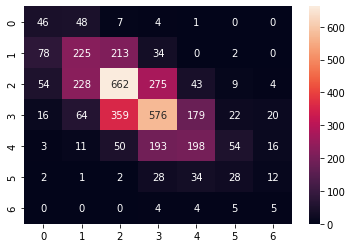

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())



dists = {
    'kneighborsclassifier__n_neighbors' : [3,5,7,9],
    'kneighborsclassifier__weights' : ['uniform','distance'],
    'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'minkowski']
}

clf= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 10,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
best_model = clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: ignored

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/model2/knn_bot.pkl') # 저장하기
#loaded_model = joblib.load('/content/drive/MyDrive/model/knn_top_half.pkl')

## 상의모델

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_after/top.csv')
df.head()

In [ ]:
df.dropna()

In [ ]:
df = df[['customer_gender','customer_height','customer_weight','customer_size','sub']]
df.dtypes
top = df

In [ ]:
df['sub'].unique()

In [ ]:
df['sub'] = df['sub'].apply(lambda x: 0  if x == 'etc' else x)
df['sub'] = df['sub'].apply(lambda x: 1  if x == 'hood' else x)
df['sub'] = df['sub'].apply(lambda x: 2  if x == 'knit' else x)
df['sub'] = df['sub'].apply(lambda x: 3  if x == 'long' else x)
df['sub'] = df['sub'].apply(lambda x: 4  if x == 'mantoman' else x)
df['sub'] = df['sub'].apply(lambda x: 5  if x == 'pk' else x)
df['sub'] = df['sub'].apply(lambda x: 6  if x == 'shirts' else x)
df['sub'] = df['sub'].apply(lambda x: 7  if x == 'sleeveless' else x)

In [ ]:
target = 'customer_size'
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)
val, test = train_test_split(test, train_size=0.50, test_size=0.50, 
                              stratify=test[target], random_state=2)

In [ ]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [ ]:
sm = SMOTE(random_state=2, k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train,y_train)
y_train.value_counts()

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())



dists = {
    'kneighborsclassifier__n_neighbors' : [3,5,7,9],
    'kneighborsclassifier__weights' : ['uniform','distance'],
    'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'minkowski']
}

clf= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 10,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
best_model = clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/model2/knn_top.pkl') # 저장하기
#loaded_model = joblib.load('/content/drive/MyDrive/model/knn_top_half.pkl')

## 스커트

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_after/skirt.csv')
df.head()

In [ ]:
df = df[['customer_gender','customer_height','customer_weight','customer_size','sub']]
df.dtypes
skirt = df

In [ ]:
df['sub'].unique()

In [ ]:
df['sub'] = df['sub'].apply(lambda x: 0  if x == 'mini' else x)
df['sub'] = df['sub'].apply(lambda x: 1  if x == 'midi' else x)
df['sub'] = df['sub'].apply(lambda x: 2  if x == 'long' else x)

In [ ]:
target = 'customer_size'
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)
val, test = train_test_split(test, train_size=0.50, test_size=0.50, 
                              stratify=test[target], random_state=2)

In [ ]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [ ]:
sm = SMOTE(random_state=2, k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train,y_train)
y_train.value_counts()

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())



dists = {
    'kneighborsclassifier__n_neighbors' : [3,5,7,9],
    'kneighborsclassifier__weights' : ['uniform','distance'],
    'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'minkowski']
}

clf= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 10,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
best_model = clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/model2/knn_skirt.pkl') # 저장하기
#loaded_model = joblib.load('/content/drive/MyDrive/model/knn_top_half.pkl')

## 아웃터


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_after/outer.csv')
df.head()

In [ ]:
df = df[['customer_gender','customer_height','customer_weight','customer_size','sub']]
df.dtypes
out = df

In [ ]:
df['sub'].unique()

In [ ]:
df['sub'] = df['sub'].apply(lambda x: 0  if x == 'cardigan' else x)
df['sub'] = df['sub'].apply(lambda x: 1  if x == 'fleece' else x)
df['sub'] = df['sub'].apply(lambda x: 2  if x == 'hood' else x)

In [ ]:
target = 'customer_size'
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)
val, test = train_test_split(test, train_size=0.50, test_size=0.50, 
                              stratify=test[target], random_state=2)

In [ ]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [ ]:
sm = SMOTE(random_state=2, k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train,y_train)
y_train.value_counts()

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())



dists = {
    'kneighborsclassifier__n_neighbors' : [3,5,7,9],
    'kneighborsclassifier__weights' : ['uniform','distance'],
    'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'minkowski']
}

clf= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 10,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
best_model = clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/model2/knn_outer.pkl') # 저장하기
#loaded_model = joblib.load('/content/drive/MyDrive/model/knn_top_half.pkl')

# 모델 하나

## knn

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_after/bot.csv')
bot = df[['customer_gender','customer_height','customer_weight','customer_size','major','sub']]

df = pd.read_csv('/content/drive/MyDrive/data_after/top.csv')
top = df[['customer_gender','customer_height','customer_weight','customer_size','major','sub']]

df = pd.read_csv('/content/drive/MyDrive/data_after/skirt.csv')
skirt = df[['customer_gender','customer_height','customer_weight','customer_size','major','sub']]

df = pd.read_csv('/content/drive/MyDrive/data_after/outer.csv')
outer = df[['customer_gender','customer_height','customer_weight','customer_size','major','sub']]

In [ ]:
top['major'] = top['major'].apply(lambda x: 0  if x == 'top' else x)
outer['major'] = outer['major'].apply(lambda x: 1  if x == 'outer' else x)
bot['major'] = bot['major'].apply(lambda x: 2  if x == 'bot' else x)
skirt['major'] = skirt['major'].apply(lambda x: 3  if x == 'skirt' else x)

In [ ]:
outer['sub'].value_counts()

hood        5552
cardigan    2969
fleece      2300
Name: sub, dtype: int64

In [ ]:
top['sub'] = top['sub'].apply(lambda x: 0  if x == 'etc' else x)
top['sub'] = top['sub'].apply(lambda x: 1  if x == 'hood' else x)
top['sub'] = top['sub'].apply(lambda x: 2  if x == 'knit' else x)
top['sub'] = top['sub'].apply(lambda x: 3  if x == 'long' else x)
top['sub'] = top['sub'].apply(lambda x: 4  if x == 'mantoman' else x)
top['sub'] = top['sub'].apply(lambda x: 5  if x == 'pk' else x)
top['sub'] = top['sub'].apply(lambda x: 6  if x == 'shirts' else x)
top['sub'] = top['sub'].apply(lambda x: 7  if x == 'sleeveless' else x)
top['sub'] = top['sub'].apply(lambda x: 8  if x == 'half' else x)

In [ ]:
outer['sub'] = outer['sub'].apply(lambda x: 9  if x == 'cardigan' else x)
outer['sub'] = outer['sub'].apply(lambda x: 10  if x == 'fleece' else x)
outer['sub'] = outer['sub'].apply(lambda x: 11  if x == 'hood' else x)

In [ ]:
bot['sub'] = bot['sub'].apply(lambda x: 12  if x == 'cot' else x)
bot['sub'] = bot['sub'].apply(lambda x: 13  if x == 'denim' else x)
bot['sub'] = bot['sub'].apply(lambda x: 14  if x == 'etc' else x)
bot['sub'] = bot['sub'].apply(lambda x: 15  if x == 'half' else x)
bot['sub'] = bot['sub'].apply(lambda x: 16  if x == 'leggings' else x)
bot['sub'] = bot['sub'].apply(lambda x: 17  if x == 'slax' else x)
bot['sub'] = bot['sub'].apply(lambda x: 18  if x == 'training' else x)

bot['customer_size'] = bot['customer_size'].apply(lambda x: 7  if x == 0 else x)
bot['customer_size'] = bot['customer_size'].apply(lambda x: 8  if x == 1 else x)
bot['customer_size'] = bot['customer_size'].apply(lambda x: 9  if x == 2 else x)
bot['customer_size'] = bot['customer_size'].apply(lambda x: 10  if x == 3 else x)
bot['customer_size'] = bot['customer_size'].apply(lambda x: 11  if x == 4 else x)
bot['customer_size'] = bot['customer_size'].apply(lambda x: 12  if x == 5 else x)
bot['customer_size'] = bot['customer_size'].apply(lambda x: 13  if x == 6 else x)

'''
7 = XS 
8 = S
9 = M
10 = L
11 = XL
12 = 2XL
13 = 3XL
'''  

'\n7 = XS \n8 = S\n9 = M\n10 = L\n11 = XL\n12 = 2XL\n13 = 3XL\n'

In [ ]:
skirt['sub'] = skirt['sub'].apply(lambda x: 19  if x == 'mini' else x)
skirt['sub'] = skirt['sub'].apply(lambda x: 20  if x == 'midi' else x)
skirt['sub'] = skirt['sub'].apply(lambda x: 21  if x == 'long' else x)

skirt['customer_size'] = skirt['customer_size'].apply(lambda x: 7  if x == 0 else x)
skirt['customer_size'] = skirt['customer_size'].apply(lambda x: 8  if x == 1 else x)
skirt['customer_size'] = skirt['customer_size'].apply(lambda x: 9  if x == 2 else x)
skirt['customer_size'] = skirt['customer_size'].apply(lambda x: 10  if x == 3 else x)

"""
바지랑 한번 같이해보고 영안나온다 싶으면 다시 나눠보자
"""


'\n바지랑 한번 같이해보고 영안나온다 싶으면 다시 나눠보자\n'

In [ ]:
dfa = pd.concat([bot,skirt,top,outer])

In [ ]:
dfa.head(10)

,customer_gender,customer_height,customer_weight,customer_size,major,sub
0,0.0,175.0,75.0,9.0,2,12
1,0.0,178.0,75.0,9.0,2,12
2,0.0,176.0,88.0,10.0,2,12
3,0.0,173.0,65.0,8.0,2,12
4,0.0,172.0,75.0,10.0,2,12
5,0.0,174.0,70.0,10.0,2,12
6,0.0,171.0,58.0,9.0,2,12
7,0.0,171.0,68.0,10.0,2,12
8,0.0,177.0,68.0,9.0,2,12
9,0.0,178.0,68.0,10.0,2,12


In [ ]:
target = 'customer_size'
train, test = train_test_split(dfa, train_size=0.80, test_size=0.20, 
                              stratify=dfa[target], random_state=2)
val, test = train_test_split(test, train_size=0.50, test_size=0.50, 
                              stratify=test[target], random_state=2)

In [ ]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [ ]:
# Number of trees in random forest
n_estimators = [10,20,30]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         0
         2.0       0.78      0.47      0.59      3235
         3.0       0.60      0.43      0.50      2736
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.69      0.44      0.54      2134
        10.0       0.67      0.44      0.53      1899
        11.0       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         0
        13.0       0.00      0.00      0.00         0

    accuracy                           0.45     10004
   macro avg       0.20      0.13      0.15     10004
weighted avg       0.69      0.45      0.54     10004



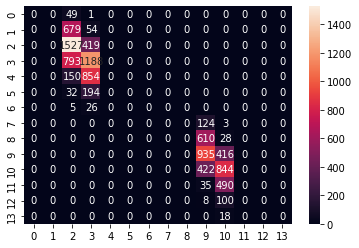

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d")

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.32      0.53      0.40       448
         2.0       0.62      0.54      0.57      2227
         3.0       0.64      0.48      0.55      2626
         4.0       0.32      0.47      0.38       670
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.39      0.52      0.45       471
         9.0       0.67      0.50      0.57      1802
        10.0       0.57      0.48      0.52      1503
        11.0       0.25      0.51      0.34       257
        12.0       0.00      0.00      0.00         0
        13.0       0.00      0.00      0.00         0

    accuracy                           0.50     10004
   macro avg       0.27      0.29      0.27     10004
weighted avg       0.57      0.50      0.53     10004



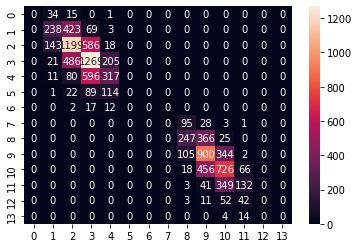

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d")

훈련 정확도:  0.5707716913234706
검증 정확도:  0.46691323470611756
              precision    recall  f1-score   support

         0.0       0.13      0.08      0.10        50
         1.0       0.40      0.40      0.40       733
         2.0       0.50      0.56      0.53      1946
         3.0       0.47      0.51      0.49      1981
         4.0       0.46      0.36      0.40      1004
         5.0       0.20      0.08      0.11       226
         6.0       0.17      0.03      0.05        31
         7.0       0.36      0.28      0.32       127
         8.0       0.42      0.48      0.45       638
         9.0       0.49      0.54      0.51      1351
        10.0       0.50      0.50      0.50      1266
        11.0       0.47      0.35      0.40       525
        12.0       0.40      0.21      0.28       108
        13.0       0.44      0.22      0.30        18

    accuracy                           0.47     10004
   macro avg       0.39      0.33      0.35     10004
weighted avg       0.46

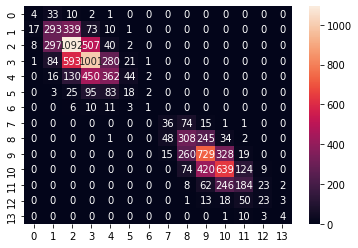

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())



dists = {
    'kneighborsclassifier__n_neighbors' : [3,5,7,9],
    'kneighborsclassifier__weights' : ['uniform','distance'],
    'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'minkowski']
}

clf= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 10,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
best_model = clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'kneighborsclassifier__weights': 'distance',
 'kneighborsclassifier__n_neighbors': 7,
 'kneighborsclassifier__metric': 'minkowski'}

              precision    recall  f1-score   support

         0.0       0.18      0.26      0.21        35
         1.0       0.39      0.39      0.39       725
         2.0       0.56      0.50      0.53      2173
         3.0       0.51      0.47      0.49      2161
         4.0       0.32      0.43      0.37       750
         5.0       0.08      0.14      0.10       121
         6.0       0.00      0.00      0.00         6
         7.0       0.33      0.36      0.34       117
         8.0       0.45      0.44      0.45       653
         9.0       0.52      0.47      0.49      1494
        10.0       0.50      0.48      0.49      1295
        11.0       0.35      0.46      0.40       397
        12.0       0.23      0.36      0.28        70
        13.0       0.22      0.57      0.32         7

    accuracy                           0.46     10004
   macro avg       0.33      0.38      0.35     10004
weighted avg       0.48      0.46      0.47     10004



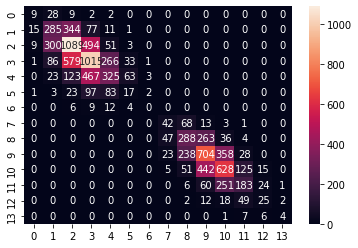

In [ ]:
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/model2/knn_one.pkl') # 저장하기
#loaded_model = joblib.load('/content/drive/MyDrive/model/knn_top_half.pkl')

['/content/drive/MyDrive/model2/knn_one.pkl']

## 랜덤포레스트

훈련 정확도:  0.6493777489004399
검증 정확도:  0.4803078768492603
              precision    recall  f1-score   support

         0.0       0.28      0.14      0.19        50
         1.0       0.43      0.35      0.39       733
         2.0       0.52      0.55      0.53      1946
         3.0       0.47      0.54      0.50      1981
         4.0       0.44      0.37      0.40      1004
         5.0       0.16      0.12      0.14       226
         6.0       0.00      0.00      0.00        31
         7.0       0.51      0.31      0.39       127
         8.0       0.50      0.44      0.47       638
         9.0       0.50      0.56      0.53      1351
        10.0       0.48      0.52      0.50      1266
        11.0       0.46      0.37      0.41       525
        12.0       0.35      0.25      0.29       108
        13.0       0.50      0.28      0.36        18

    accuracy                           0.48     10004
   macro avg       0.40      0.34      0.36     10004
weighted avg       0.47 

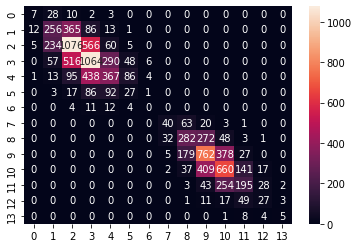

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier())

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred) 
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
dists = {
    'randomforestclassifier__max_depth' : [3,5,10,15],
    'randomforestclassifier__max_features' : [3,5,10],
    'randomforestclassifier__n_estimators' : [80, 100, 150, 200]
}

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier())


# 최적값을 구하고 싶은 파라미터를 정리 


# RandomizedSearchCV 작성
clf1= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 500,   # random search 탐색 횟수
    cv = 5,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )

best_model = clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'randomforestclassifier__n_estimators': 10,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 4}

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier())


dists = {
    'randomforestclassifier__n_estimators' : n_estimators,
    'randomforestclassifier__max_features' : max_features,
    'randomforestclassifier__max_depth' : max_depth,
    'randomforestclassifier__min_samples_split' :min_samples_split ,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf
    #'randomforestclassifier__bootstrap': bootstrap
}

clf= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 10,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='f1',  # 오차 평가방법 accuracy
    verbose=1,     # 진행상황
    random_state = 2
  )

best_model = clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'randomforestclassifier__n_estimators': 10,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 4}